In [45]:
import pandas as pd
import numpy as np
import random
import os

In [46]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

In [48]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

In [49]:
# 'Industry_Status',
# 'Hispanic_Origin',
# 'Household_Status',
# 'Birth_Country',
# 'Birth_Country (Father)', 
# 'Birth_Country (Mother)'

In [50]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [51]:
train.columns

Index(['ID', 'Age', 'Gender', 'Education_Status', 'Employment_Status',
       'Working_Week (Yearly)', 'Industry_Status', 'Occupation_Status', 'Race',
       'Hispanic_Origin', 'Martial_Status', 'Household_Status',
       'Household_Summary', 'Citizenship', 'Birth_Country',
       'Birth_Country (Father)', 'Birth_Country (Mother)', 'Tax_Status',
       'Gains', 'Losses', 'Dividends', 'Income_Status', 'Income'],
      dtype='object')

### modify age

In [52]:
def modify_age(age):
    if age < 15:
        return 0
    elif age < 25:
        return 1
    elif age < 40:
        return 2
    elif age < 50:
        return 3
    elif age < 65:
        return 4
    elif age < 80:
        return 5
    else:
        return 6

In [53]:
train['Age'] = train['Age'].apply(modify_age)
test['Age'] = test['Age'].apply(modify_age)

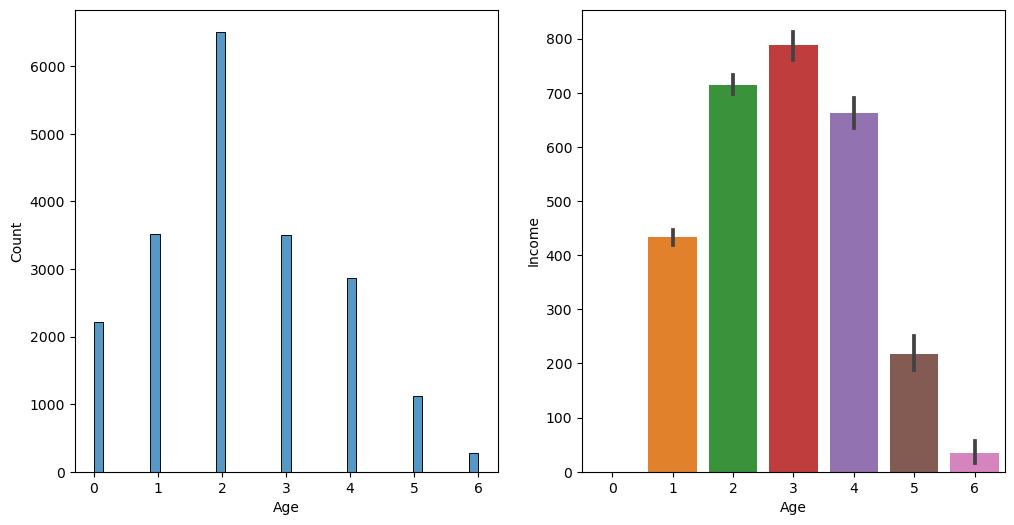

In [54]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(x='Age', data=train)

plt.subplot(1, 2, 2)
sns.barplot(x='Age', y='Income', data=train)
plt.show()

### modify education

In [55]:
def modify_education(education):
    if education in ['Children', 'Kindergarten', 'Elementary (1-4)', 'Elementary (5-6)', 
                     'Middle (7-8)', 'High Freshman', 'High Sophomore', 
                     'High Junior', 'High Senior']:
        return 'dropout'
    elif education in ['College', 'Associates degree (Academic)', 'Associates degree (Vocational)']:
        return 'CommunityCollege'
    elif education in ['Professional degree', 'Masters degree']:
        return 'Masters degree'
    else:
        return education

In [56]:
train['Education'] = train['Education_Status']
train['Education'] = train['Education'].apply(modify_education)

In [57]:
test['Education'] = test['Education_Status']
test['Education'] = test['Education'].apply(modify_education)

### household/tax

### modify household

In [58]:
np.unique(train['Household_Summary'])

array(['Child 18 or older', 'Child under 18 ever married',
       'Child under 18 never married',
       'Group Quarters- Secondary individual', 'Householder',
       'Nonrelative of householder', 'Other relative of householder',
       'Spouse of householder'], dtype=object)

In [59]:
def modify_household(household):
    if household == 'Householder':
        return 'Householder'
    elif household in ['Child 18 or older', 'Child under 18 ever married', 'Child under 18 never married', 
                     'Other relative of householder', 'Spouse of householder']:
        return 'dependents'
    else:
        return 'others'

In [60]:
train['Household_Summary'] = train['Household_Summary'].apply(modify_household)
test['Household_Summary'] = test['Household_Summary'].apply(modify_household)

### modify tax status

In [61]:
def modify_tax(tax):
    if tax.startswith('Married'):
        return 'MFJ'
    else:
        return tax

In [62]:
train['Tax_Status'] = train['Tax_Status'].apply(modify_tax)
test['Tax_Status'] = test['Tax_Status'].apply(modify_tax)

<Axes: xlabel='Count', ylabel='Tax_Status'>

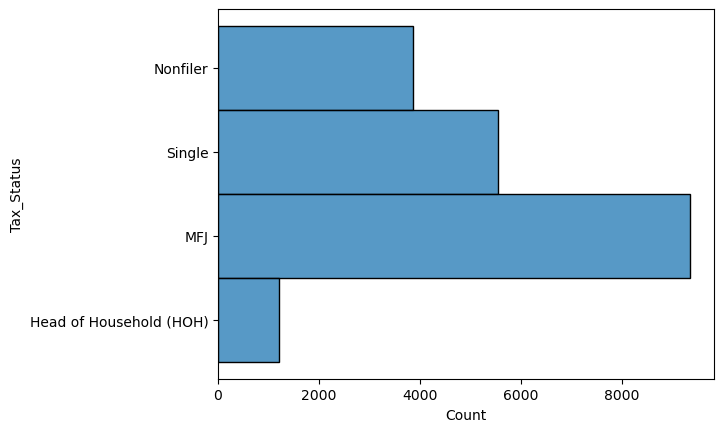

In [63]:
sns.histplot(y='Tax_Status', data=train)

### modify income status

In [64]:
def modify_income_status(status):
    if status in ['Unknown', 'Under Median']:
        return 'Under Median'
    else:
        return status

In [65]:
train['Income_Status'] = train['Income_Status'].apply(modify_income_status)
test['Income_Status'] = test['Income_Status'].apply(modify_income_status)

### working week

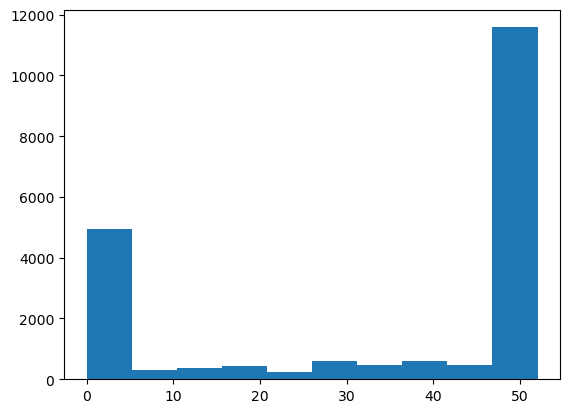

In [66]:
plt.hist(train['Working_Week (Yearly)'])
plt.show()

In [67]:
sum(train['Working_Week (Yearly)']<52), sum(train['Working_Week (Yearly)']==52)

(9387, 10613)

In [68]:
train['Working_Week (Yearly)'] = np.where(train['Working_Week (Yearly)']<52, 0, 1)
test['Working_Week (Yearly)'] = np.where(test['Working_Week (Yearly)']<52, 0, 1)

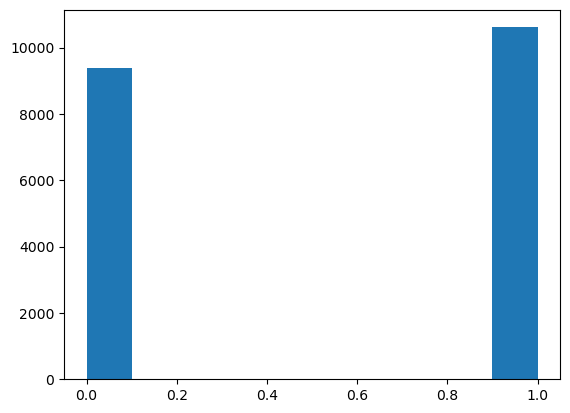

In [69]:
plt.hist(train['Working_Week (Yearly)'])
plt.show()

### gain, loss, dividend

In [70]:
# train['Gains'] = np.where(train['Gains']>0, 1, 0)
# test['Gains'] = np.where(test['Gains']>0, 1, 0)

# train['Losses'] = np.where(train['Losses']>0, 1, 0)
# test['Losses'] = np.where(test['Losses']>0, 1, 0)

# train['Dividends'] = np.where(train['Dividends']>0, 1, 0)
# test['Dividends'] = np.where(test['Dividends']>0, 1, 0)

In [71]:
train['Capital'] = train['Gains'] + train['Dividends'] - train['Losses']
test['Capital'] = test['Gains'] + test['Dividends'] - test['Losses']

train['Capital'] = np.where(train['Capital']>0, 1, 0)
test['Capital'] = np.where(test['Capital']>0, 1, 0)

### main

In [72]:
trainval_x = train.drop(columns=['ID', 'Income', 
                                #  'Industry_Status',
                                 'Hispanic_Origin', 
                                 'Household_Status', 
                                 'Birth_Country', 
                                 'Birth_Country (Father)', 'Birth_Country (Mother)',
                                 'Education_Status',
                                 'Gains', 'Losses', 'Dividends'
                                 ])

trainval_y = train['Income']
income_over = train['Income'] > 875
# trainval_y = np.log(train['Income']+1)

test_x = test.drop(columns=['ID',
                            # 'Industry_Status',
                            'Hispanic_Origin', 
                            'Household_Status', 
                            'Birth_Country', 
                            'Birth_Country (Father)', 'Birth_Country (Mother)',
                            'Education_Status',
                            'Gains', 'Losses', 'Dividends'
                            ])

In [73]:
trainval_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Age                    20000 non-null  int64 
 1   Gender                 20000 non-null  object
 2   Employment_Status      20000 non-null  object
 3   Working_Week (Yearly)  20000 non-null  int32 
 4   Industry_Status        20000 non-null  object
 5   Occupation_Status      20000 non-null  object
 6   Race                   20000 non-null  object
 7   Martial_Status         20000 non-null  object
 8   Household_Summary      20000 non-null  object
 9   Citizenship            20000 non-null  object
 10  Tax_Status             20000 non-null  object
 11  Income_Status          20000 non-null  object
 12  Education              20000 non-null  object
 13  Capital                20000 non-null  int32 
dtypes: int32(2), int64(1), object(11)
memory usage: 2.0+ MB


In [74]:
encoding_target = list(trainval_x.dtypes[trainval_x.dtypes == "object"].index)

save_encoder = None
for i in encoding_target:
    le = LabelEncoder()

    # train과 test 데이터셋에서 해당 열의 모든 값을 문자열로 변환
    trainval_x[i] = trainval_x[i].astype(str)
    test_x[i] = test_x[i].astype(str)
    
    le.fit(trainval_x[i])
    trainval_x[i] = le.transform(trainval_x[i])
    
    # test 데이터의 새로운 카테고리에 대해 le.classes_ 배열에 추가
    for case in np.unique(test_x[i]):
        if case not in le.classes_: 
            print('case')
            le.classes_ = np.append(le.classes_, case)
    
    test_x[i] = le.transform(test_x[i])

    if i == 'Occupation_Status':
        save_encoder = le
        print(f'{i}_save')

    if len(np.unique(trainval_x[i])) == 2:
        print(i)
        continue

    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore') ## ignore로 학습 데이터셋에 없는 데이터가 들어와도 무시
    train_encoded = ohe.fit_transform(trainval_x[[i]])

    train_encoded_df = pd.DataFrame(train_encoded, columns=[f"{i}_{j}" for j in range(train_encoded.shape[1])])
    trainval_x = pd.concat([trainval_x.drop(columns=[i]), train_encoded_df], axis=1)
    
    test_encoded = ohe.transform(test_x[[i]])
    
    test_encoded_df = pd.DataFrame(test_encoded, columns=[f"{i}_{j}" for j in range(test_encoded.shape[1])])
    test_x = pd.concat([test_x.drop(columns=[i]), test_encoded_df], axis=1)

Gender
Occupation_Status_save
Income_Status


In [75]:
trainval_x.head()

,Age,Gender,Working_Week (Yearly),Income_Status,Capital,Employment_Status_0,Employment_Status_1,Employment_Status_2,Employment_Status_3,Employment_Status_4,...,Tax_Status_0,Tax_Status_1,Tax_Status_2,Tax_Status_3,Education_0,Education_1,Education_2,Education_3,Education_4,Education_5
0,4,1,0,1,0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2,1,1,1,0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,4,0,1,1,1,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,3,1,1,1,0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,2,0,1,1,0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [76]:
kf = StratifiedKFold(n_splits=5, shuffle=True)

1 fold
train error : 545.86 | val error : 637.55
[post] train error : 545.77 | val error : 637.44
------------------------------


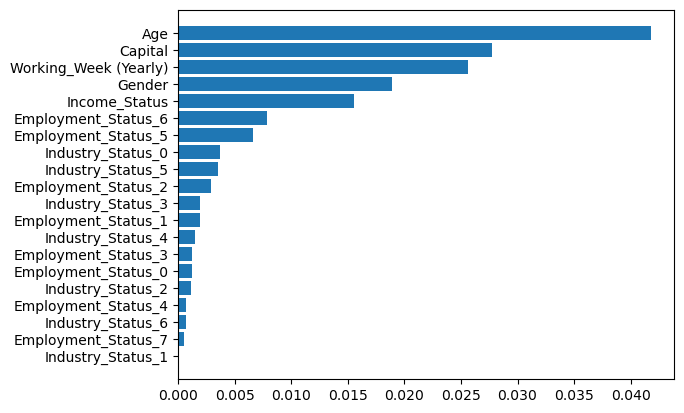

2 fold
train error : 538.79 | val error : 663.54
[post] train error : 538.72 | val error : 663.48
------------------------------


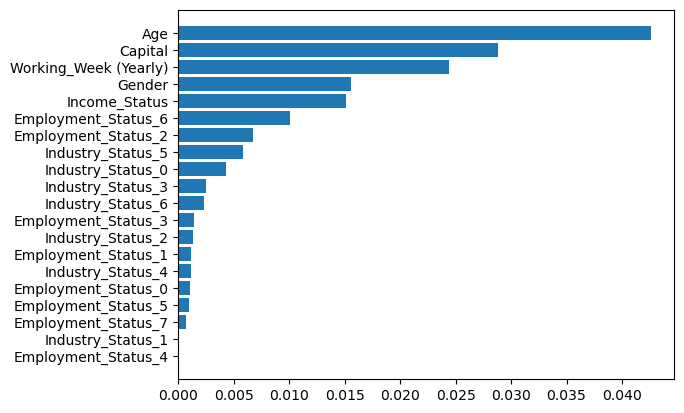

3 fold
train error : 555.35 | val error : 587.82
[post] train error : 555.28 | val error : 587.76
------------------------------


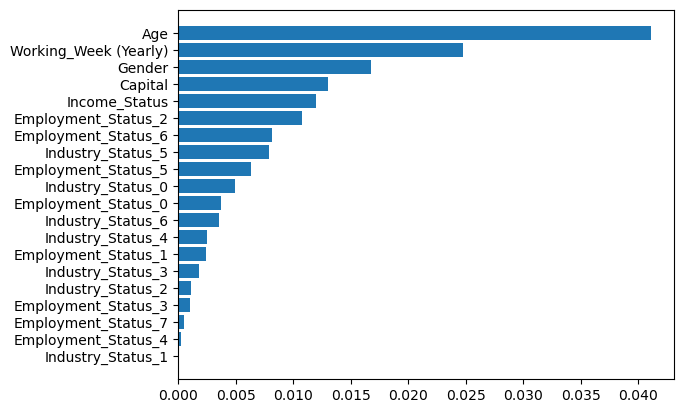

4 fold
train error : 564.67 | val error : 560.40
[post] train error : 564.62 | val error : 560.29
------------------------------


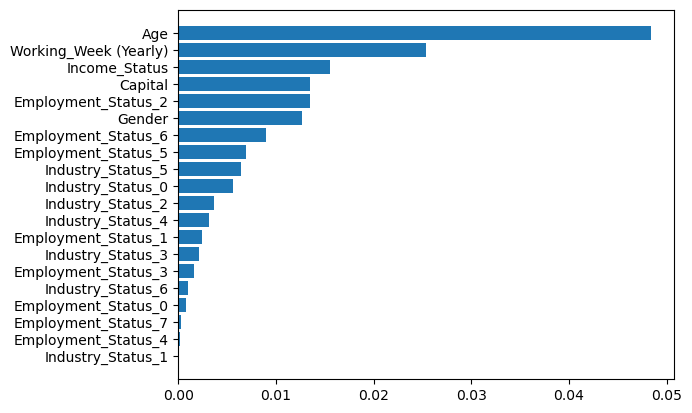

5 fold
train error : 567.70 | val error : 524.56
[post] train error : 567.62 | val error : 524.50
------------------------------


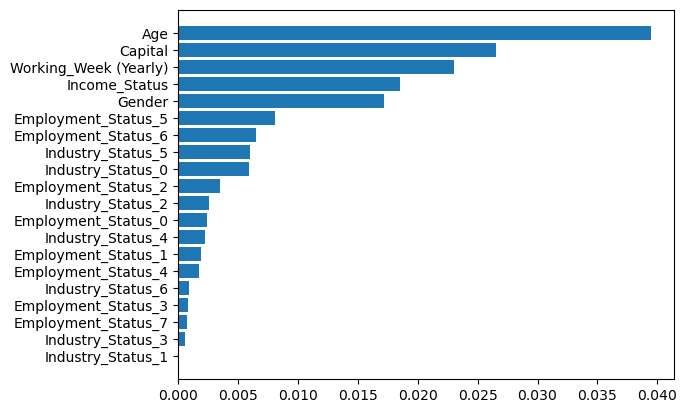

In [77]:
num_fold = 1
total_train_error, total_val_error = 0, 0
total_train_error_post, total_val_error_post = 0, 0
test_preds = []
for train_idx, val_idx in kf.split(trainval_x, income_over):
    train_x = trainval_x.iloc[train_idx]
    train_y = trainval_y.iloc[train_idx]

    val_x = trainval_x.iloc[val_idx]
    val_y = trainval_y.iloc[val_idx]

    model = GradientBoostingRegressor(max_depth=4)
    model.fit(train_x, train_y)

    print(f'{num_fold} fold')

    train_y_hat = model.predict(train_x)
    val_y_hat = model.predict(val_x)

    pred = model.predict(test_x)
    test_preds.append(pred)

    train_error = mean_squared_error(train_y, train_y_hat) ** 0.5
    val_error = mean_squared_error(val_y, val_y_hat) ** 0.5

    total_train_error += train_error
    total_val_error += val_error

    train_y_hat_post = np.where(train_y_hat<0, 0, train_y_hat)
    val_y_hat_post = np.where(val_y_hat<0, 0, val_y_hat)

    train_error_post = mean_squared_error(train_y, train_y_hat_post) ** 0.5
    val_error_post = mean_squared_error(val_y, val_y_hat_post) ** 0.5

    total_train_error_post += train_error_post
    total_val_error_post += val_error_post

    print(f'train error : {train_error:.2f} | val error : {val_error:.2f}')
    print(f'[post] train error : {train_error_post:.2f} | val error : {val_error_post:.2f}')
    
    print('-'*30)

    feature_importances = model.feature_importances_
    importance_df = pd.Series(feature_importances[:20], index=trainval_x.columns[:20])
    importance_df.sort_values(inplace=True)

    plt.barh(np.arange(len(importance_df)), importance_df)
    plt.yticks(np.arange(len(importance_df)), importance_df.index)
    plt.show()

    num_fold += 1

In [78]:
save_encoder.inverse_transform([6])

array(['Management'], dtype=object)

In [79]:
print(f'final train error : {total_train_error/5:.2f}')
print(f'final val error : {total_val_error/5:.2f}')

print(f'[post] final train error : {total_train_error_post/5:.2f}')
print(f'[post] final val error : {total_val_error_post/5:.2f}')

final train error : 554.47
final val error : 594.77
[post] final train error : 554.40
[post] final val error : 594.70


### age 
final train error : 554.47
final val error : 594.77
[post] final train error : 554.40
[post] final val error : 594.70

### depth 4
final train error : 548.84
final val error : 596.10
[post] final train error : 548.78
[post] final val error : 596.04

#### working day 추가
final train error : 550.06
final val error : 595.10
[post] final train error : 549.99
[post] final val error : 595.02

### records

#### stratify
final train error : 557.18
final val error : 596.77
[post] final train error : 557.14
[post] final val error : 596.71

#### household 수정
final train error : 557.47
final val error : 596.23
[post] final train error : 557.42
[post] final val error : 596.17

In [80]:
final_pred = np.array(test_preds).mean(0)

In [81]:
final_pred_post = np.where(final_pred<0, 0, final_pred)

In [82]:
# final_pred_exp = np.exp(final_pred)-1

In [83]:
submission = pd.read_csv('data/sample_submission.csv')

In [84]:
submission['Income'] = final_pred
submission['Income'] = final_pred_post
# submission['Income'] = final_pred_exp
submission

,ID,Income
0,TEST_0000,3.619761
1,TEST_0001,20.001104
2,TEST_0002,404.529550
3,TEST_0003,539.936209
4,TEST_0004,0.513671
...,...,...
9995,TEST_9995,882.878093
9996,TEST_9996,720.757135
9997,TEST_9997,390.310908
9998,TEST_9998,0.513671


In [85]:
os.makedirs('submission', exist_ok=True)
# submission.to_csv('submission/stratify_0323_engineering_5.csv', index=False)

(array([1., 0., 0., 0., 0., 1., 0., 0., 1., 1.]),
 array([2135.22755446, 2222.58383612, 2309.94011778, 2397.29639944,
        2484.6526811 , 2572.00896276, 2659.36524442, 2746.72152608,
        2834.07780774, 2921.4340894 , 3008.79037106]),
 <BarContainer object of 10 artists>)

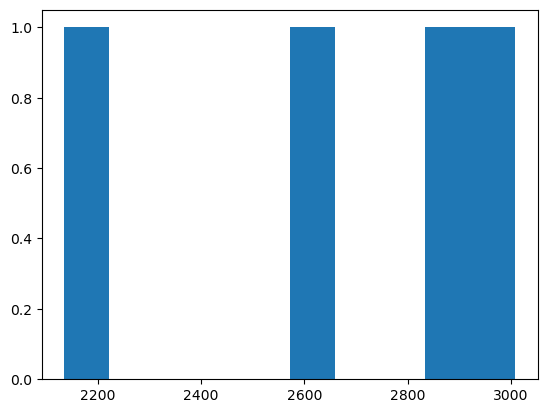

In [86]:
plt.hist(final_pred_post[final_pred_post>2000])